In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.8 MB/s eta 0:00:00


In [2]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
from datetime import datetime
import random

# library for statistics
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor #Multicollinearity

# library for machine learning
import sklearn
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor

%matplotlib inline

## 1. Data Processing

### 1-1 Data Load

In [3]:
df = pd.read_csv('Steel_industry_data.csv')
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


### 1-2 Duplication Check

In [4]:
len(df[df.duplicated()])

0

## 2.Data EDA

### 2-1 Data Type and Summary

In [5]:
df.shape

(35040, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [7]:
# categorical and numerical columns

for column_name in list(df.columns):
  print(column_name, df[column_name].unique())

date ['01/01/2018 00:15' '01/01/2018 00:30' '01/01/2018 00:45' ...
 '31/12/2018 23:30' '31/12/2018 23:45' '31/12/2018 00:00']
Usage_kWh [ 3.17  4.    3.24 ... 21.89 17.82 45.  ]
Lagging_Current_Reactive.Power_kVarh [ 2.95  4.46  3.28 ... 69.77 74.56 70.67]
Leading_Current_Reactive_Power_kVarh [ 0.    0.18 15.66 16.96 21.28 19.22 16.88 22.32 18.   16.92 23.4   5.65
  4.82  6.7   4.57 12.89 23.15 16.67 16.63 23.33 16.74 16.99 18.25 22.1
 16.7  19.33 21.35 16.81 20.45 20.77 21.64 19.19 23.51 17.39 17.35  8.96
  5.47 16.24 22.57 20.74 20.88 22.54 19.55 17.42 24.26 17.75 25.2  17.5
 10.08  0.07  0.11  0.94  1.15  0.54  0.14 18.9  25.92 25.34 25.49  6.52
  1.04  0.5   1.58  0.43  1.37  0.47  3.96 12.13 23.22 25.16 26.5  26.42
 26.46 15.44  0.04 26.21 25.56 25.74  6.08  1.69  1.94  0.79  1.66  1.22
  6.98 23.83 24.8  26.82 26.78 15.16 18.79 26.39 26.89  1.19  3.46  2.12
  2.77 24.08 25.78 25.85 14.65 20.2  26.32 25.81  7.6   3.56  0.61  4.43
 17.64 24.05 26.68 26.64 26.6  15.19 20.7  20.99 19

In [8]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64', 'int64']).columns)
target_column = 'Usage_kWh'
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

35040
11
4
7


In [9]:
df.isnull().sum()

,0
date,0
Usage_kWh,0
Lagging_Current_Reactive.Power_kVarh,0
Leading_Current_Reactive_Power_kVarh,0
CO2(tCO2),0
Lagging_Current_Power_Factor,0
Leading_Current_Power_Factor,0
NSM,0
WeekStatus,0
Day_of_week,0


### 2-2 Dependent Data (Target) Exploration

In [10]:
list_numeric_columns.remove(target_column)

In [11]:
df[target_column].describe()

,Usage_kWh
count,35040.000000
mean,27.386892
std,33.444380
min,0.000000
25%,3.200000
50%,4.570000
75%,51.237500
max,157.180000


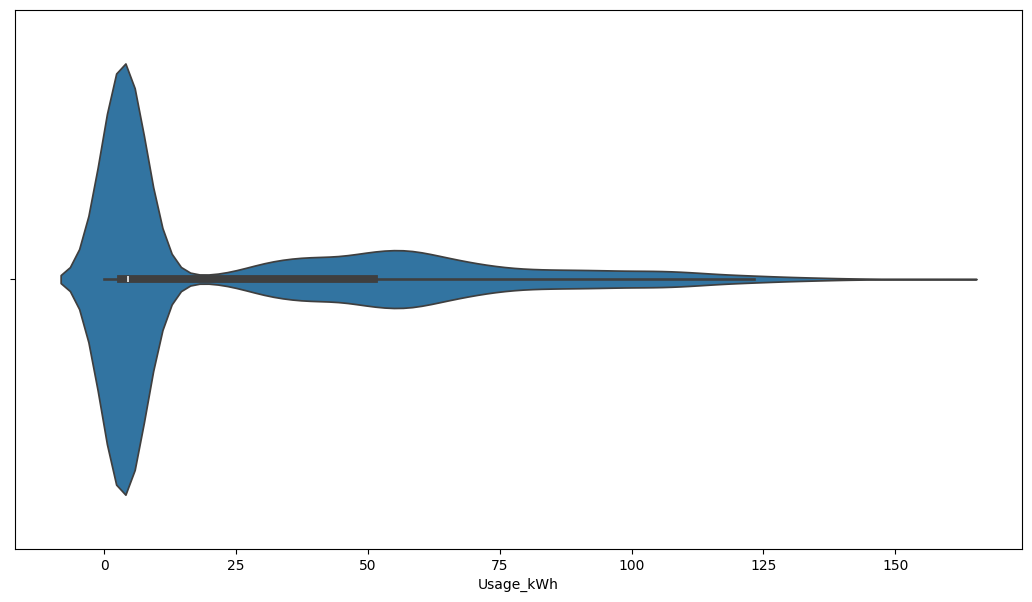

In [12]:
# There is diverese electricity usage across the range between 0 and 150

plt.figure(figsize=(13,7))
sns.violinplot(x=target_column, data=df)
plt.show()

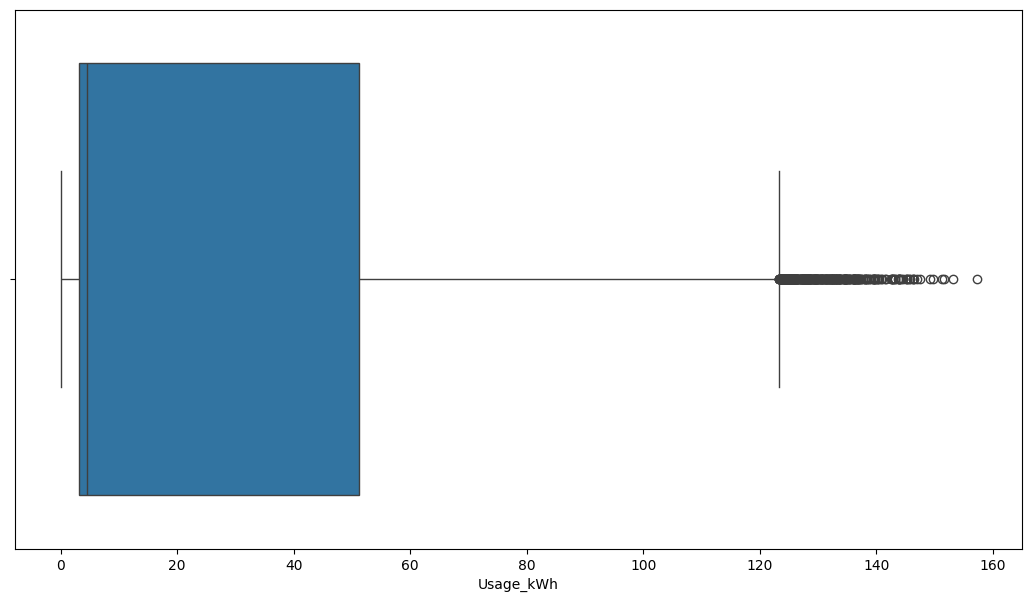

In [13]:
# But most of the time, 0 to 55

plt.figure(figsize=(13,7))
sns.boxplot(x=target_column, data=df)
plt.show()

### 2-3 Independent Data (Feature variable) Exploration

#### a) Categorical Variables

In [14]:
df[list_categorical_columns].nunique().sort_values()

,0
WeekStatus,2
Load_Type,3
Day_of_week,7
date,35040


In [15]:
# date's unique values has the same number of entire data, so it seems like it is not really helpful

df = df.drop('date', axis=1)
list_categorical_columns.remove('date')

* Insight:
1. Of course, we have 5 days of weekday and 2 days of weekend. That is why bar is higher for weekday
2. There are three types of electricity usage type, and this factory used electricity for light load task most of the time

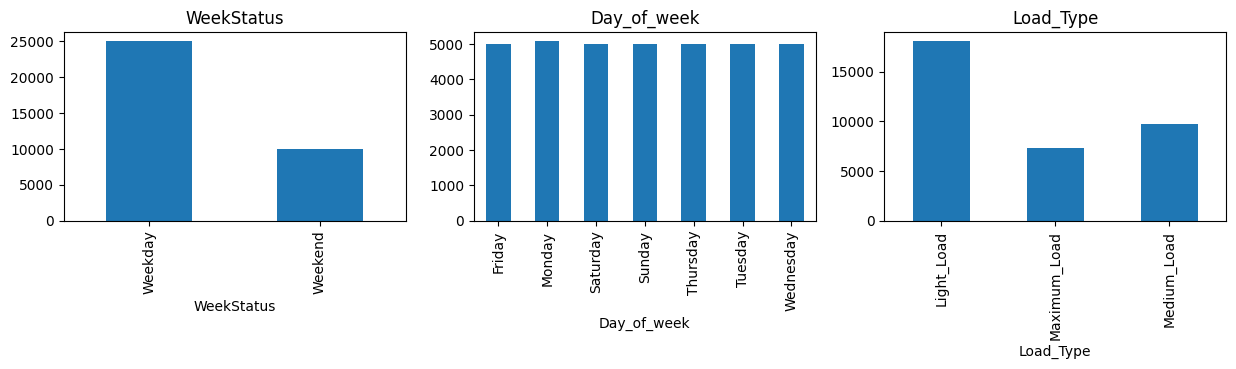

In [16]:
# Distribution check per categorical column

plt.figure(figsize=(15,5))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.6, wspace=0.2)
for column_name in list_categorical_columns:
  plt.subplot(2,3,x)
  x = x+1
  df[column_name].value_counts().sort_index().plot(kind='bar')
  plt.title(column_name)
plt.show()

In [17]:
list_categorical_columns

['WeekStatus', 'Day_of_week', 'Load_Type']

In [18]:
df.columns

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

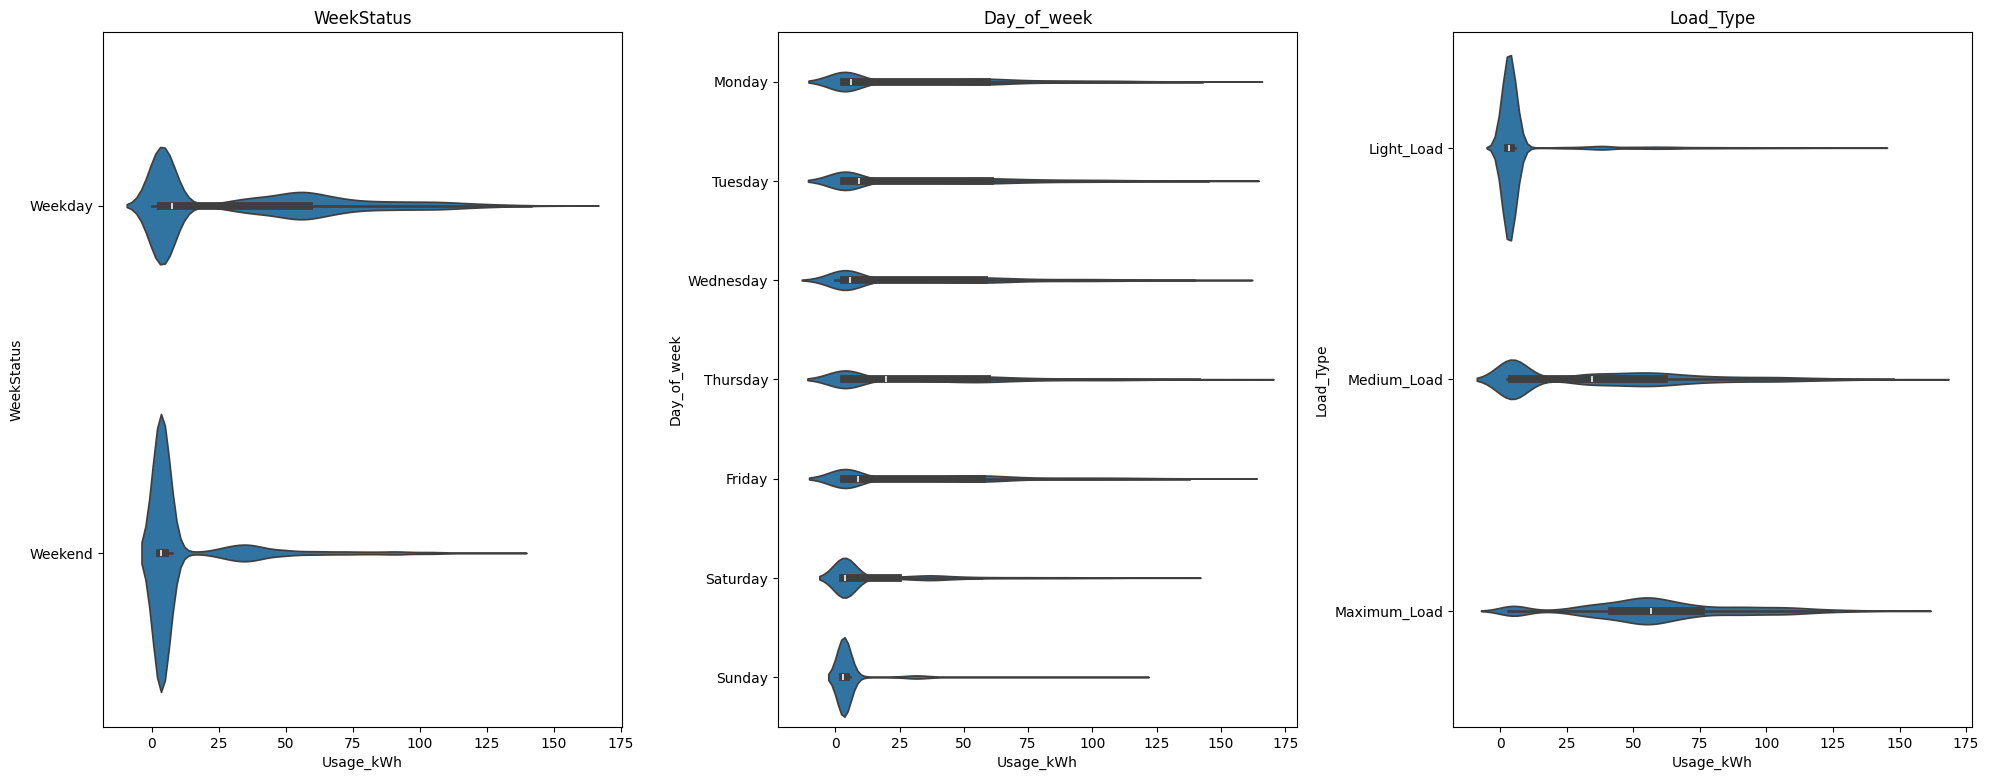

In [19]:
# distribution comparision between categorical columns and target column

plt.figure(figsize=(20,15))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.6, wspace=0.2)
for column_name in list_categorical_columns:
  plt.subplot(2,3,x)
  x = x+1
  sns.violinplot(x=df['Usage_kWh'], y=column_name, data=df)
  plt.title(column_name)
  plt.xlabel('Usage_kWh')
  plt.ylabel(column_name)
plt.tight_layout()
plt.show()

((array([-4.11001814, -3.90040449, -3.78597164, ...,  3.78597164,
          3.90040449,  4.11001814]),
  array([  0.  ,   2.45,   2.45, ..., 151.67, 153.14, 157.18])),
 (29.028230694480264, 27.386892408675788, 0.8678683117181271))

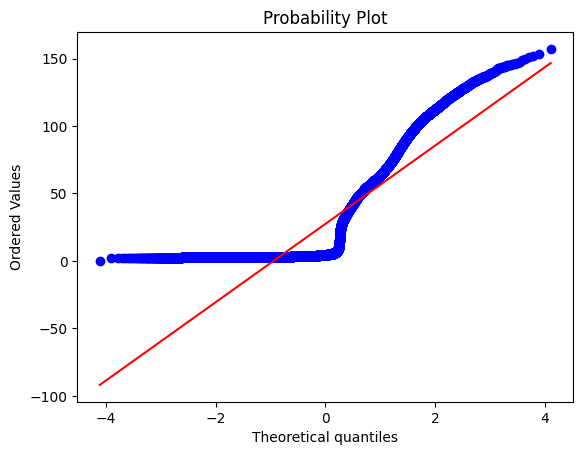

In [20]:
# numerical columns normality check (QQ plot)
# our target columns is not normalized

stats.probplot(df[target_column], dist=stats.norm, plot=plt)

In [21]:
# Box-cox and log transformation shows p value less than 0.05 which means that our target value is not normalized
# Since this happens, we are unable to verify variance analysis with target column

scaler = StandardScaler()

list_positive = (df[target_column] > 0)
statistic, pvalue = stats.shapiro(pd.DataFrame(scaler.fit_transform(boxcox(df[list_positive][target_column])[0].reshape(-1,1))))
print(statistic, pvalue)
statistic, pvalue = stats.shapiro(np.log(df[list_positive][target_column]))
print(statistic, pvalue)

0.8021563321513807 3.723768197519827e-106
0.792064531932032 1.833003432523285e-107


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35039.
  res = hypotest_fun_out(*samples, **kwds)


In [22]:
list_categorical_columns

['WeekStatus', 'Day_of_week', 'Load_Type']

### Insight:

1. Every categorical data has meaningful relationship between our target value
2. Every categorical data should be used for trainning our ML model

In [23]:
list_meaningful_column_by_kruskal = []

for column_name in list_categorical_columns:
  list_kruskal = []
  for value in df[column_name].unique():
    df_tmp = df[df[column_name] == value][target_column].dropna()
    list_kruskal.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_kruskal)
  if pvalue < 0.05:
    list_meaningful_column_by_kruskal.append(column_name)
  print(column_name, ", ", statistic, ", ", pvalue)
print("All numerical columns: ", len(list_categorical_columns))
print("Meaningful columns: ", len(list_meaningful_column_by_kruskal), list_meaningful_column_by_kruskal)

WeekStatus ,  3449.689686099411 ,  0.0
Day_of_week ,  3928.0670950109625 ,  0.0
Load_Type ,  17109.099132500152 ,  0.0
All numerical columns:  3
Meaningful columns:  3 ['WeekStatus', 'Day_of_week', 'Load_Type']


#### b) Numerical Variable

In [24]:
# Looks fine

df[list_numeric_columns].nunique().sort_values()

,0
CO2(tCO2),8
NSM,96
Leading_Current_Reactive_Power_kVarh,768
Lagging_Current_Reactive.Power_kVarh,1954
Leading_Current_Power_Factor,3366
Lagging_Current_Power_Factor,5079


In [25]:
df[list_numeric_columns].describe()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


### Check distributions per numerical columns

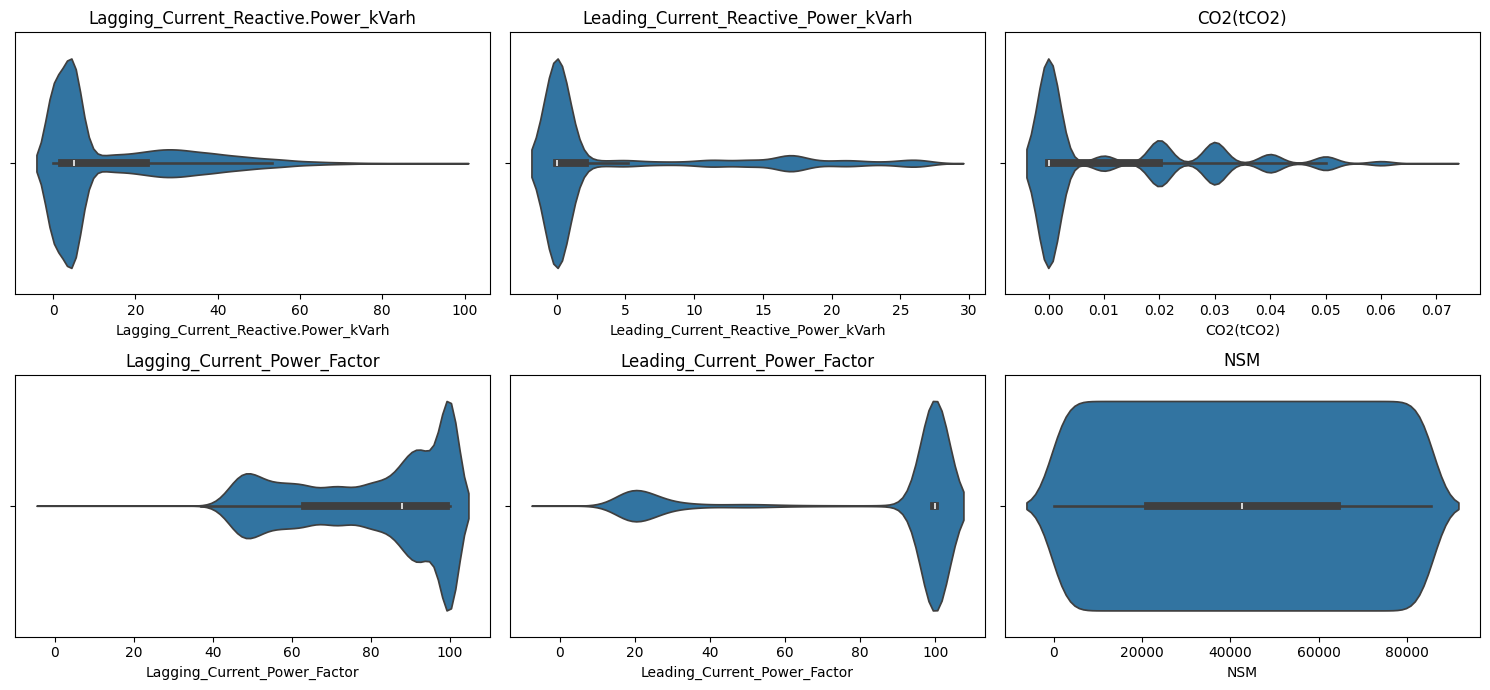

In [26]:
plt.figure(figsize=(15,7))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.6, wspace=0.2)
for column_name in list_numeric_columns:
  plt.subplot(2,3,x)
  x = x+1
  sns.violinplot(x=df[column_name], data=df)
  plt.title(column_name)

plt.tight_layout()
plt.show()

In [27]:
# Scailing for numerical columns will be needed

for column_name in list_numeric_columns:
  print(column_name, "Skewness: ", skew(df[column_name]), "Kurtosis: ", kurtosis(df[column_name]))

Lagging_Current_Reactive.Power_kVarh Skewness:  1.437837778494172 Kurtosis:  1.213491942207817
Leading_Current_Reactive_Power_kVarh Skewness:  1.7342394993641692 Kurtosis:  1.5807002774831105
CO2(tCO2) Skewness:  1.1493053042522912 Kurtosis:  0.21440364507335374
Lagging_Current_Power_Factor Skewness:  -0.6061002810740537 Kurtosis:  -1.0958388365207652
Leading_Current_Power_Factor Skewness:  -1.5119195199967073 Kurtosis:  0.3830746981323694
NSM Skewness:  0.0 Kurtosis:  -1.2002604449267498


#### c) Correlation Analysis

<Axes: >

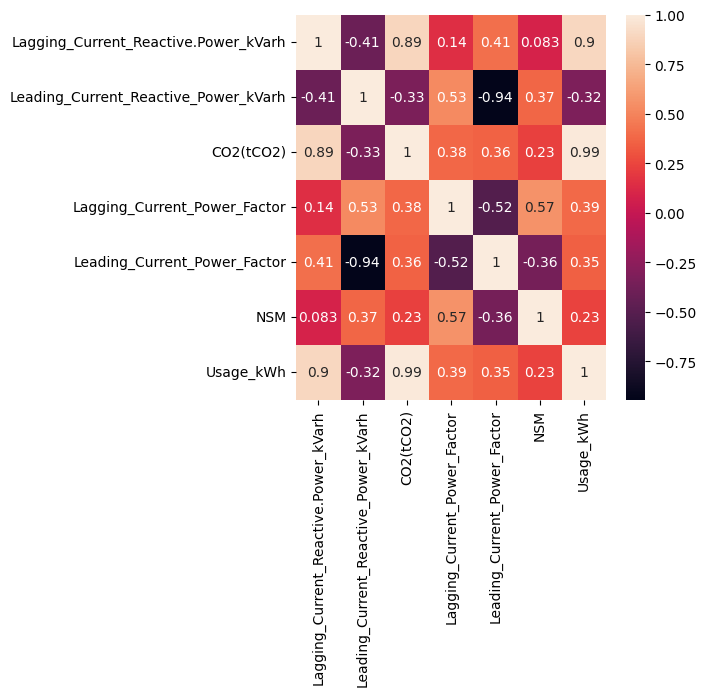

In [28]:
# Some numerical features have high correlations

df_corr = df[list_numeric_columns + [target_column]].corr()

plt.figure(figsize=(5,5))
sns.heatmap(df_corr, annot=True)

In [29]:
index_corr_over_90 = np.where((abs(df_corr) > 0.9) & (df_corr != 1))
index_corr_over_90

(array([1, 2, 4, 6]), array([4, 6, 1, 2]))

In [30]:
# Leading_Current_Reactive_Power_kVarh <-> Leading_Current_Power_Factor
# These two independent variable has high correlations so we drop one of them
# Domain knowledge also helps to drop columns (if possible)

len_corr_over_90 = len(index_corr_over_90[0])

left_columns = df_corr.columns[index_corr_over_90[0]]
right_columns = df_corr.columns[index_corr_over_90[1]]

for i in range(len_corr_over_90):
  print(left_columns[i], "<->", right_columns[i])


Leading_Current_Reactive_Power_kVarh <-> Leading_Current_Power_Factor
CO2(tCO2) <-> Usage_kWh
Leading_Current_Power_Factor <-> Leading_Current_Reactive_Power_kVarh
Usage_kWh <-> CO2(tCO2)


In [31]:
list_removed_by_correlation = ['Lagging_Current_Power_Factor']

### VIF Analysis

* Generally, if VIF is bigger than 10, it assumes that there is multi-collinearity, but we assume 20 in this case

In [32]:
def calculate_vif(df_target):
  vif = pd.DataFrame()
  vif['VIF_Factor'] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif['Feature'] = df_target.columns
  return vif

df_vif = df[list_numeric_columns].copy()

In [33]:
df_vif

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
0,2.95,0.00,0.0,73.21,100.00,900
1,4.46,0.00,0.0,66.77,100.00,1800
2,3.28,0.00,0.0,70.28,100.00,2700
3,3.56,0.00,0.0,68.09,100.00,3600
4,4.50,0.00,0.0,64.72,100.00,4500
...,...,...,...,...,...,...
35035,4.86,0.00,0.0,62.10,100.00,82800
35036,3.74,0.00,0.0,70.71,100.00,83700
35037,3.17,0.07,0.0,76.62,99.98,84600
35038,3.06,0.11,0.0,77.72,99.96,85500


In [34]:
calculate_vif(df_vif)

,VIF_Factor,Feature
0,8.636740,Lagging_Current_Reactive.Power_kVarh
1,7.724869,Leading_Current_Reactive_Power_kVarh
2,9.804016,CO2(tCO2)
3,37.857911,Lagging_Current_Power_Factor
4,19.399309,Leading_Current_Power_Factor
5,5.983350,NSM


In [35]:
df_vif2 = df_vif.drop(list_removed_by_correlation, axis=1).copy()
final_vif = calculate_vif(df_vif2)

In [36]:
final_vif

,VIF_Factor,Feature
0,8.272288,Lagging_Current_Reactive.Power_kVarh
1,2.239935,Leading_Current_Reactive_Power_kVarh
2,7.940691,CO2(tCO2)
3,3.634448,Leading_Current_Power_Factor
4,5.343007,NSM


In [37]:
list_numeric_feature_by_vif = list(final_vif['Feature'].values)
print(list_numeric_feature_by_vif)
print(len(list_numeric_feature_by_vif))

['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Leading_Current_Power_Factor', 'NSM']
5


### Relationship check between target column and numerical column

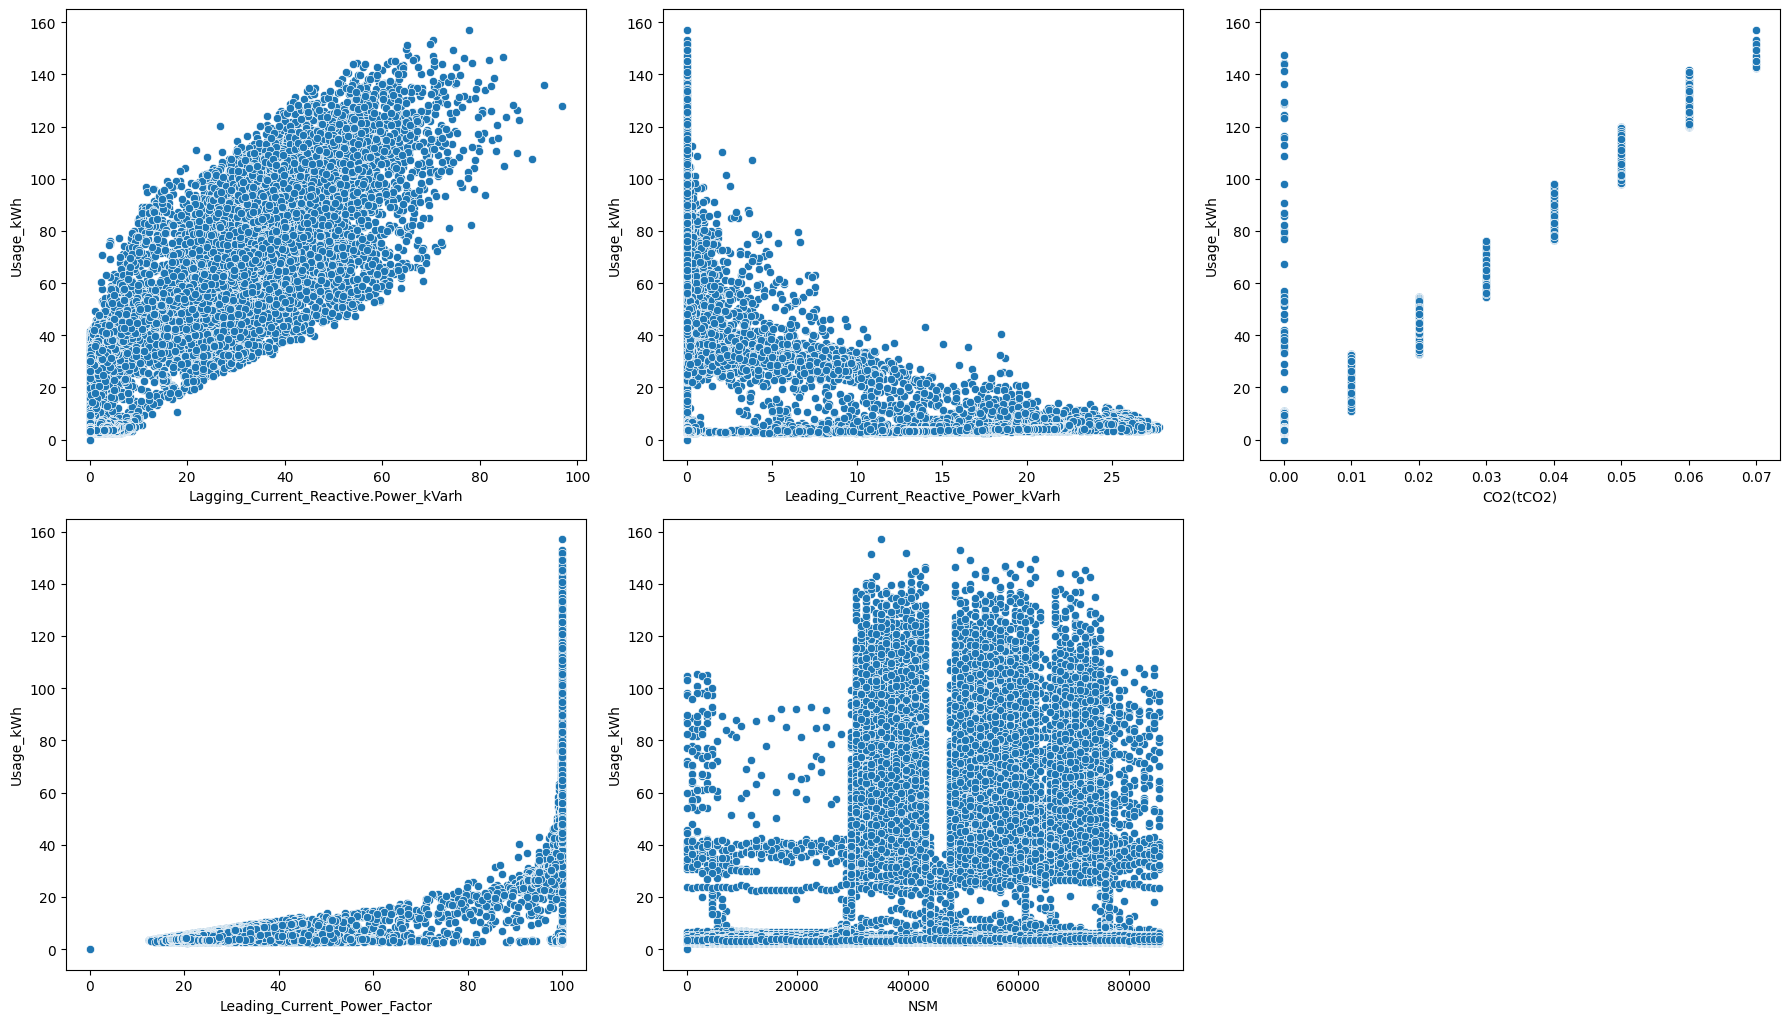

In [38]:
plt.figure(figsize=(18,15))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.6, wspace=0.2)
for column_name in list_numeric_feature_by_vif:
  plt.subplot(3,3,x)
  x = x+1
  sns.scatterplot(x=column_name, y=df['Usage_kWh'], data=df)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### 3-1 Feature Selection

In [39]:
df = df[[target_column] + list_categorical_columns + list_numeric_feature_by_vif]

list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['int64', 'float64']).columns)

print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

9
3
6


### 3-2 Missing Values

In [40]:
df.isnull().sum()

,0
Usage_kWh,0
WeekStatus,0
Day_of_week,0
Load_Type,0
Lagging_Current_Reactive.Power_kVarh,0
Leading_Current_Reactive_Power_kVarh,0
CO2(tCO2),0
Leading_Current_Power_Factor,0
NSM,0


### 3-3 Feature Transformation

In [41]:
list_numeric_columns.remove(target_column)

In [42]:
Y = df[target_column]
X = df.drop(target_column, axis=1)

In [43]:
X.head(1)

,WeekStatus,Day_of_week,Load_Type,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Leading_Current_Power_Factor,NSM
0,Weekday,Monday,Light_Load,2.95,0.0,0.0,100.0,900


In [44]:
# MinMaxScailing for numerical values

scaler = MinMaxScaler()
X[list_numeric_columns] = scaler.fit_transform(X[list_numeric_columns])
X.head(1)

,WeekStatus,Day_of_week,Load_Type,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Leading_Current_Power_Factor,NSM
0,Weekday,Monday,Light_Load,0.030441,0.0,0.0,1.0,0.010526


In [45]:
# One-hot encoding for categorical values

X_base = pd.get_dummies(X)
X_base.head(1)

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Leading_Current_Power_Factor,NSM,WeekStatus_Weekday,WeekStatus_Weekend,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,0.030441,0.0,0.0,1.0,0.010526,True,False,False,True,False,False,False,False,False,True,False,False


In [46]:
len(X_base.columns)

17

### 3-4 Summary

1. Feature selection by VIF analysis and correlation
2. Normalization
3. No Dimension Reduction

X_base, Y

## 4. Model Analysis

#### 4.1 Random Forest

In [47]:
cv = 3
n_jobs = -1

In [48]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y, test_size=0.3, random_state=42)

In [49]:
rf_clf = RandomForestRegressor(max_depth = 4, n_estimators = 5)
rf_clf.fit(X_train, y_train)
y_prd = rf_clf.predict(X_validation)
score = mean_squared_error(y_prd, y_validation)**0.5
print("RMSE: ", score)

RMSE:  3.8598980012470943


### 4.2 Optimization 1: BayesSearchCV with RandomForest

- Finding the best parameter using Hyper-parameter tuning (GridSearch, Randomsearch, BayesSearch)
- Cross validation is performed automatically

In [50]:
def objective(trial):
    # Define search space
    max_depth = trial.suggest_int("max_depth", 10, 35)
    n_estimators = trial.suggest_int("n_estimators", 100, 200)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 6)
    max_features = trial.suggest_float("max_features", 0.9, 1.0)
    criterion = trial.suggest_categorical("criterion", ["squared_error"])

    # Define model with sampled parameters
    model = RandomForestRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Perform cross-validation
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error").mean()

    return -score  # Minimize RMSE (negative because Optuna maximizes by default)

# Run Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=16, show_progress_bar=True)

# Print Best Parameters
print("Best Hyperparameters:", study.best_params)

# Train model with best parameters
best_model = RandomForestRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = best_model.predict(X_validation)
rmse = mean_squared_error(y_validation, y_pred) ** 0.5
print('\n')
print("RMSE:", rmse)

[I 2025-02-15 00:56:32,630] A new study created in memory with name: no-name-2c139551-cea4-4e2a-bece-5e0f344390da


  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-02-15 00:57:08,660] Trial 0 finished with value: 3.375922852298673 and parameters: {'max_depth': 34, 'n_estimators': 154, 'min_samples_split': 3, 'max_features': 0.9950236432214447, 'criterion': 'squared_error'}. Best is trial 0 with value: 3.375922852298673.
[I 2025-02-15 00:57:26,835] Trial 1 finished with value: 3.3341083081271132 and parameters: {'max_depth': 19, 'n_estimators': 159, 'min_samples_split': 6, 'max_features': 0.9224449975471669, 'criterion': 'squared_error'}. Best is trial 1 with value: 3.3341083081271132.
[I 2025-02-15 00:57:43,407] Trial 2 finished with value: 3.3577547434413595 and parameters: {'max_depth': 28, 'n_estimators': 129, 'min_samples_split': 4, 'max_features': 0.9238383719460939, 'criterion': 'squared_error'}. Best is trial 1 with value: 3.3341083081271132.
[I 2025-02-15 00:57:58,506] Trial 3 finished with value: 3.3663101118565866 and parameters: {'max_depth': 27, 'n_estimators': 116, 'min_samples_split': 4, 'max_features': 0.9107475614795024, '

### 4.3 Optimization 2: BayesSearchCV with XGBoostRegresor

In [51]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Ensure X_train and y_train are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

# Define the Optuna objective function for XGBoost
def objective(trial):
    # Define hyperparameter search space
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-9, 100.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 100.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 5000),
    }

    # Train XGBoost model on X_train
    model = XGBRegressor(random_state=42, booster="gbtree", objective="reg:squarederror", **params)
    model.fit(X_train, y_train)

    # Predict on X_validation
    y_pred = model.predict(X_validation)

    # Compute RMSE
    rmse = mean_squared_error(y_validation, y_pred)**0.5

    return rmse  # Minimize RMSE

# Run Optuna Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Print Best Parameters
print("Best Hyperparameters:", study.best_params)

# Train final model with best parameters on full dataset
best_model = XGBRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

# Predict & Evaluate on X_validation
y_pred = best_model.predict(X_validation)
rmse = mean_squared_error(y_validation, y_pred)**0.5  # Direct RMSE computation

print("\nFinal XGBoost RMSE:", rmse)

[I 2025-02-15 01:01:46,638] A new study created in memory with name: no-name-ef8c1f0c-b633-4a7b-9aa6-43182bc2f0ba


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-02-15 01:01:50,621] Trial 0 finished with value: 3.182223577984078 and parameters: {'learning_rate': 0.13890274373763917, 'max_depth': 7, 'subsample': 0.28426075118527616, 'colsample_bytree': 0.9404808084385429, 'reg_lambda': 93.86168655844291, 'reg_alpha': 82.24840153985924, 'n_estimators': 1454}. Best is trial 0 with value: 3.182223577984078.
[I 2025-02-15 01:01:52,583] Trial 1 finished with value: 3.1646286437615085 and parameters: {'learning_rate': 0.3568163402744198, 'max_depth': 5, 'subsample': 0.8520840598222678, 'colsample_bytree': 0.748051009175045, 'reg_lambda': 80.56932429895156, 'reg_alpha': 43.026629693828326, 'n_estimators': 1273}. Best is trial 1 with value: 3.1646286437615085.
[I 2025-02-15 01:01:55,344] Trial 2 finished with value: 3.327086321968534 and parameters: {'learning_rate': 0.36427504250590537, 'max_depth': 7, 'subsample': 0.2363582399476271, 'colsample_bytree': 0.25955581874535033, 'reg_lambda': 71.15119436787323, 'reg_alpha': 40.64553866506071, 'n_es

In [52]:
study.best_params

{'learning_rate': 0.019400266663084323,
 'max_depth': 8,
 'subsample': 0.536897411647229,
 'colsample_bytree': 0.8841831194497853,
 'reg_lambda': 62.99523414951475,
 'reg_alpha': 78.82256389686711,
 'n_estimators': 3955}

### 4-2 Model Analysis

### Feature Importance

In [53]:
# reproduction

xgb_clf = XGBRegressor(**study.best_params)
final_model = xgb_clf.fit(X_train, y_train)

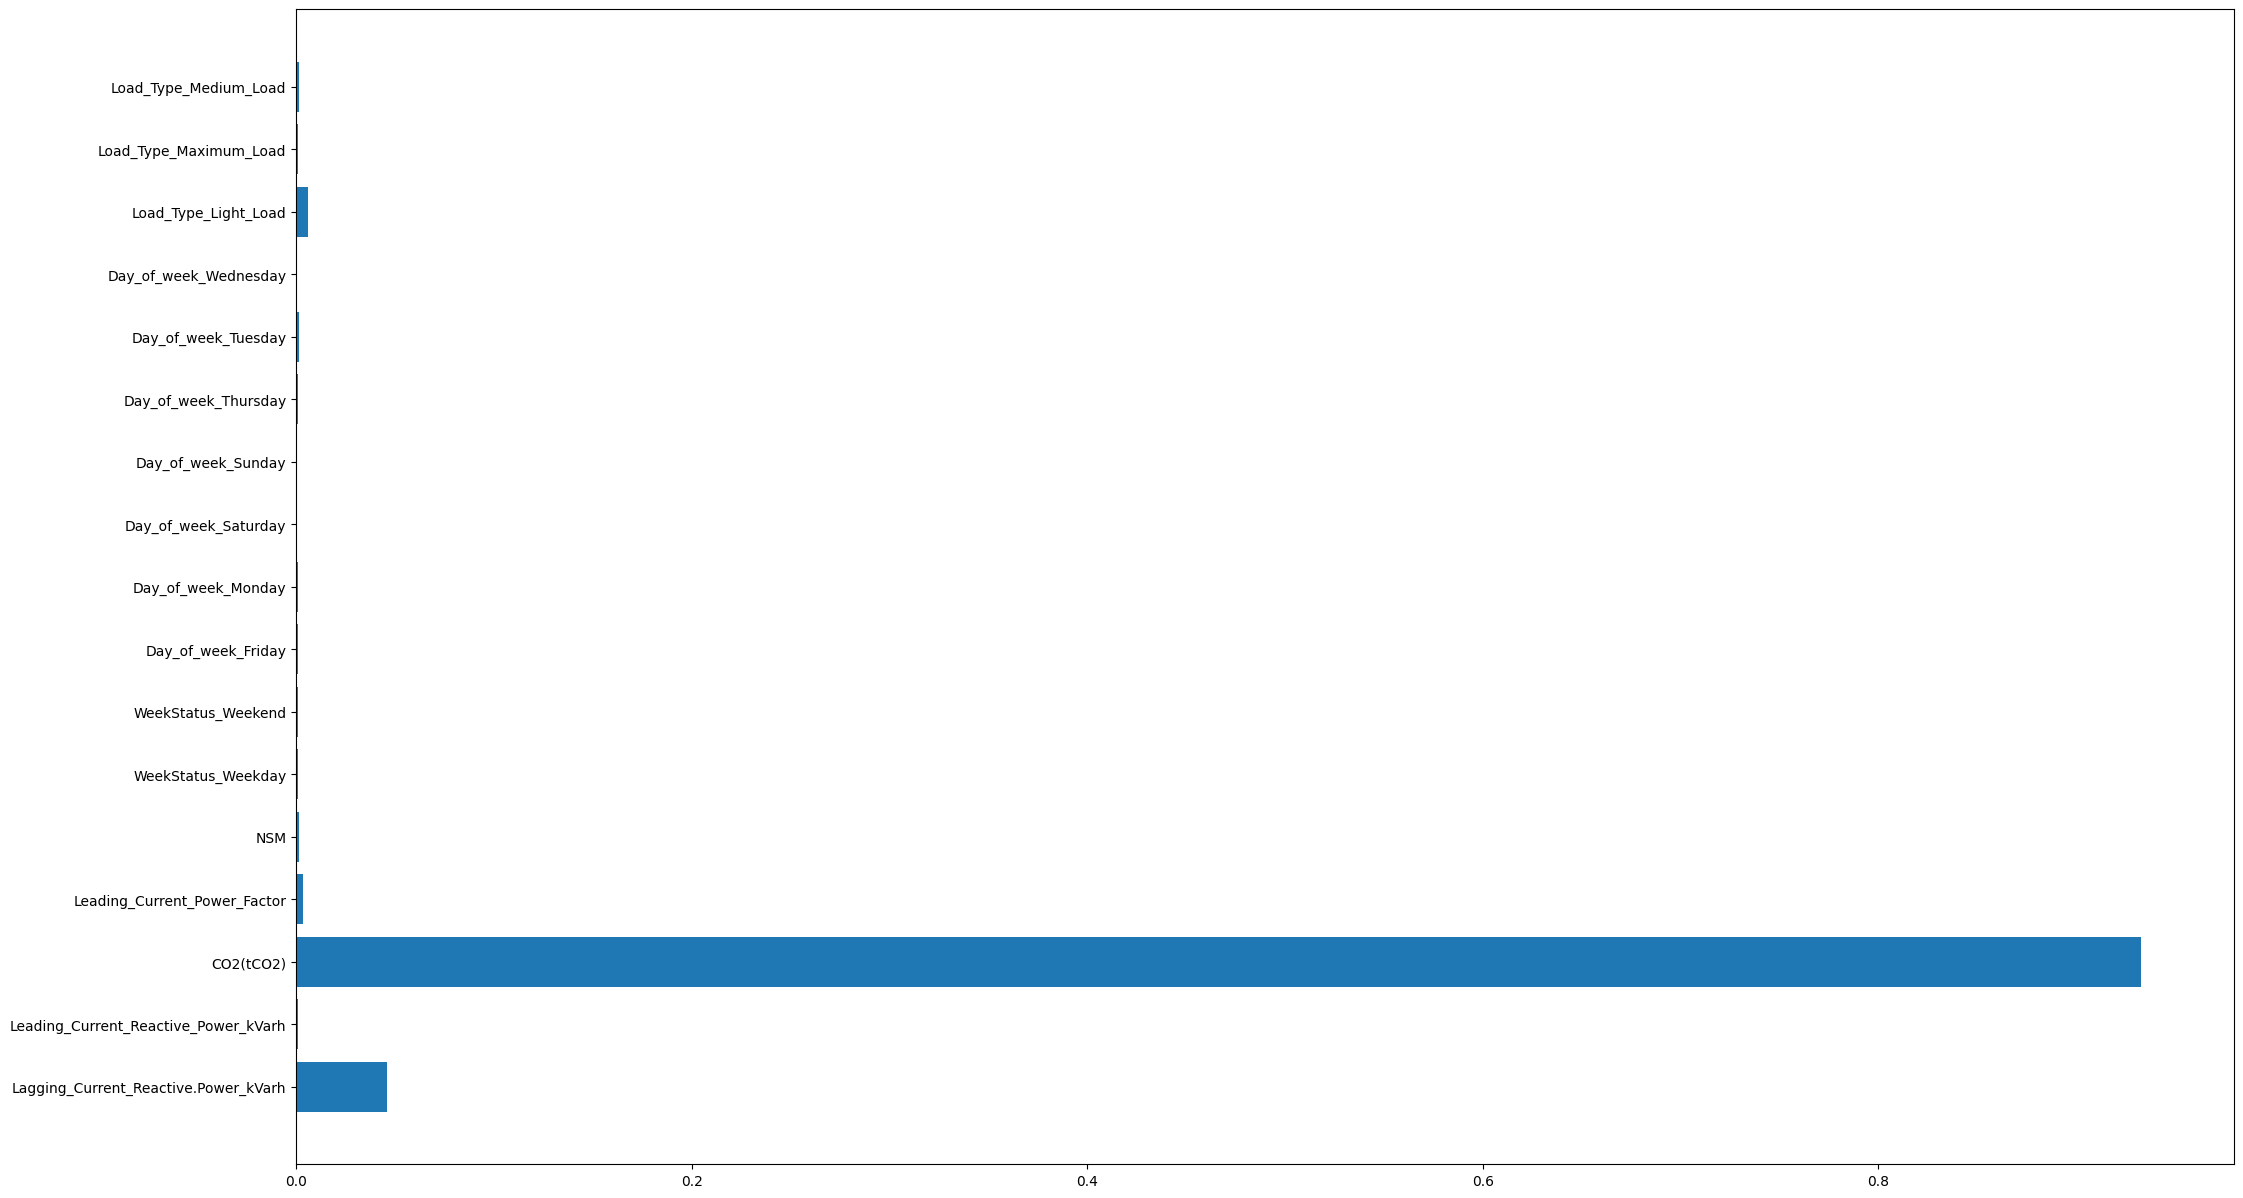

In [54]:
plt.figure(figsize=(25,15))
ax = plt.barh(list(X_base.columns), final_model.feature_importances_)

In [55]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [56]:
lr.intercept_

2.7325234006948698

In [57]:
lr.coef_

array([ 2.60819874e+01,  1.88943253e+00,  1.23172900e+02,  1.29549740e+00,
        1.11945948e-01, -4.59069456e-02,  4.59069456e-02, -1.59190899e-01,
       -1.62058650e-01, -1.62272770e-01,  2.08179716e-01, -2.36435542e-01,
        6.15886642e-01, -1.04108497e-01, -1.83015415e+00,  8.05208764e-01,
        1.02494538e+00])

In [60]:
y_pred = lr.predict(X_validation)
score = mean_squared_error(y_prd, y_validation)**0.5
print("R_squared for testing:", round(lr.score(X_validation,y_validation),4))
print("RMSE: ", score)

R_squared for testing: 0.9837
RMSE:  3.8598980012470943
